In [ ]:
from plot_utils import plot_coordination_histograms, plot_graph_structure, plot_cluster_size_distribution, plot_cluster_composition_analysis, plot_3d_cluster_visualization, plot_3d_cluster_with_graph, analyze_bond_network, plot_rdfs


In [1]:
from ovito.io import import_file
from ovito.modifiers import CreateBondsModifier, SelectTypeModifier
from ovito.data import BondsEnumerator
import networkx as nx
import numpy as np

In [2]:
# --- user inputs ---
infile = "/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.40/T1100K/dump.lammpstrj"

# Modified cutoffs: Disable Pu-Cl bonds
r_PuCl = 0.0   # DISABLED: No Pu-Cl bonds
r_NaCl = None   # Will be determined from RDF first minimum

In [3]:
# Set up pipeline and RDF calculation to determine proper cutoffs
from ovito.modifiers import CoordinationAnalysisModifier
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the trajectory ONCE - we'll reuse this pipeline throughout
pipe = import_file(infile, multiple_frames=True)
print(f"Loaded trajectory with {pipe.source.num_frames} frames")

# Add RDF calculation modifier with partial RDFs enabled
rdf_modifier = CoordinationAnalysisModifier(
    cutoff=8.0,  # Maximum distance for RDF calculation
    number_of_bins=200,
    partial=True  # Enable partial RDFs for different atom pairs
)
pipe.modifiers.append(rdf_modifier)
print("Added RDF modifier to pipeline")

# (Optional) ensure types exist and have names 'Pu','Na','Cl' in your dump.

Loaded trajectory with 24588 frames
Added RDF modifier to pipeline


In [7]:
# Function to calculate RDFs and find first minimum distances
def calculate_rdfs_and_cutoffs(pipeline, nsamples=500):
    """Calculate RDFs and find first minimum distances for bond cutoffs"""
    nframes = pipeline.source.num_frames
    rdf_data = {}
    
    print(f"Calculating RDFs from last {nsamples} frames...")
    
    for frame in tqdm(range(nframes - nsamples, nframes)):
        data = pipeline.compute(frame)
        # Access the output DataTable:
        rdf_table = data.tables['coordination-rdf']
        
        # The y-property of the data points of the DataTable is now a vectorial property.
        # Each vector component represents one partial RDF.
        rdf_names = rdf_table.y.component_names
        
        # Process each partial RDF
        for component, name in enumerate(rdf_names):
            elements = sorted(name.split('-'))
            unique_name = '-'.join(elements)
            
            y = rdf_table.y[:,component]
            if rdf_data.get(unique_name, None) is None:
                rdf_data[unique_name] = [y]
            else:
                rdf_data[unique_name].append(y)
    
    # Average over all frames
    for name in rdf_data:
        rdf_data[name] = np.vstack(rdf_data[name]).mean(axis=0)
    
    rdf_data["r"] = rdf_table.xy()[:, 0]
    
    return rdf_data

# Function to find first minimum in RDF
def find_first_minimum(r, g_r, min_distance=1.0, max_distance=6.0):
    """Find the first minimum in g(r) between min_distance and max_distance"""
    # Filter the range
    mask = (r >= min_distance) & (r <= max_distance)
    r_filtered = r[mask]
    g_filtered = g_r[mask]
    
    if len(g_filtered) < 3:
        return None
    
    # Find local minima
    from scipy.signal import find_peaks
    # Invert g(r) to find minima as peaks
    peaks, _ = find_peaks(g_filtered)   # g(r) should be > 0.5 for a minimum
    
    if len(peaks) > 0:
        # Return the first minimum
        return r_filtered[peaks[0]]
    else:
        # Fallback: find where g(r) first drops below 1.0 after the first peak
        first_peak_idx = np.argmax(g_filtered)
        for i in range(first_peak_idx, len(g_filtered)):
            if g_filtered[i] < 1.0:
                return r_filtered[i]
        return None


In [8]:
# Calculate RDFs and determine cutoffs
print("Calculating RDFs to determine bond cutoffs...")
rdf_data = calculate_rdfs_and_cutoffs(pipe, nsamples=100)  # Use fewer samples for speed

# Find cutoffs for metal-chlorine pairs
r = rdf_data["r"]

# Check what RDFs we actually have
print(f"Available RDFs: {list(rdf_data.keys())}")

# Cl-Pu cutoff (alphabetical order) - DISABLED
print(f"Cl-Pu bonds DISABLED: r_PuCl = {r_PuCl:.3f} Å")

# Cl-Na cutoff (alphabetical order)
if "Cl-Na" in rdf_data:
    r_NaCl = find_first_minimum(r, rdf_data["Cl-Na"], min_distance=2.0, max_distance=5.0)
    print(f"Cl-Na first minimum: {r_NaCl:.3f} Å")
elif "total" in rdf_data:
    # Use total RDF as fallback
    r_NaCl = find_first_minimum(r, rdf_data["total"], min_distance=2.0, max_distance=5.0)
    print(f"Using total RDF for Cl-Na cutoff: {r_NaCl:.3f} Å")
else:
    r_NaCl = 3.10  # fallback
    print("Cl-Na RDF not found, using fallback cutoff")

print(f"Using cutoffs: r_PuCl = {r_PuCl:.3f} Å (DISABLED), r_NaCl = {r_NaCl:.3f} Å")


Calculating RDFs to determine bond cutoffs...
Calculating RDFs from last 100 frames...


100%|██████████| 100/100 [00:01<00:00, 66.88it/s]

Available RDFs: ['Na-Na', 'Cl-Na', 'Na-Pu', 'Cl-Cl', 'Cl-Pu', 'Pu-Pu', 'r']
Cl-Pu bonds DISABLED: r_PuCl = 0.000 Å
Cl-Na first minimum: 2.660 Å
Using cutoffs: r_PuCl = 0.000 Å (DISABLED), r_NaCl = 2.660 Å


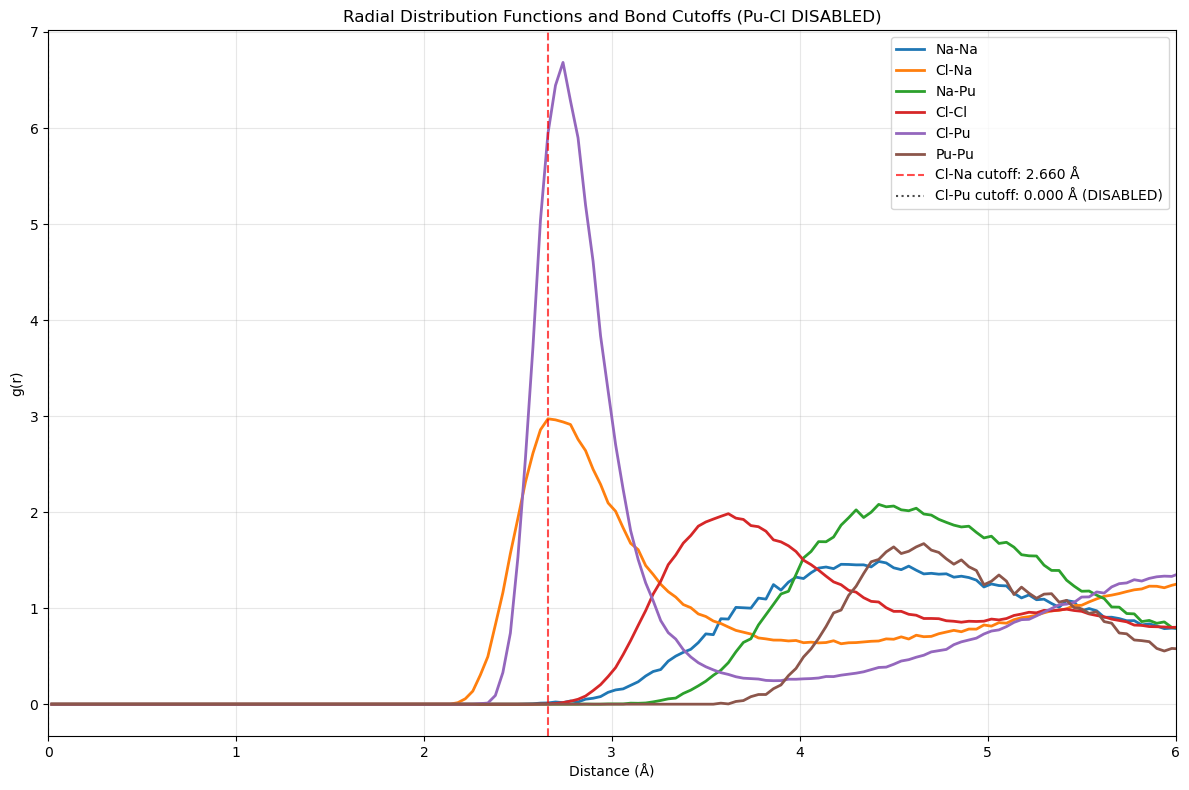


RDF Data Summary:
Number of distance points: 200
Distance range: 0.020 - 7.980 Å
Na-Na: max g(r) = 1.487 at r = 4.420 Å
Cl-Na: max g(r) = 2.972 at r = 2.660 Å
Na-Pu: max g(r) = 2.080 at r = 4.420 Å
Cl-Cl: max g(r) = 1.984 at r = 3.620 Å
Cl-Pu: max g(r) = 6.683 at r = 2.740 Å
Pu-Pu: max g(r) = 1.672 at r = 4.660 Å


In [10]:
# Plot the RDFs to visualize the cutoffs
plt.figure(figsize=(12, 8))

# Plot all available RDFs
for name, g_r in rdf_data.items():
    if name != "r":
        plt.plot(r, g_r, label=name, linewidth=2)

# Mark the determined cutoffs

if r_NaCl:
    plt.axvline(r_NaCl, color='red', linestyle='--', alpha=0.7, label=f'Cl-Na cutoff: {r_NaCl:.3f} Å')

# Mark Pu-Cl as disabled
plt.axvline(0, color='black', linestyle=':', alpha=0.7, label=f'Cl-Pu cutoff: {r_PuCl:.3f} Å (DISABLED)')

plt.xlabel('Distance (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Functions and Bond Cutoffs (Pu-Cl DISABLED)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 6)
# plt.ylim(0, 5)
plt.tight_layout()
plt.show()

# Print some diagnostic information
print(f"\nRDF Data Summary:")
print(f"Number of distance points: {len(r)}")
print(f"Distance range: {r[0]:.3f} - {r[-1]:.3f} Å")
for name, g_r in rdf_data.items():
    if name != "r":
        print(f"{name}: max g(r) = {np.max(g_r):.3f} at r = {r[np.argmax(g_r)]:.3f} Å")


In [11]:
# Now modify the existing pipeline for cluster analysis with RDF-determined cutoffs
# Remove the RDF modifier and add bond creation with calculated cutoffs
print("Removing RDF modifier and adding bond creation...")
pipe.modifiers.clear()  # Remove RDF modifier

# Create bonds using RDF-determined cutoffs
cb = CreateBondsModifier(mode=CreateBondsModifier.Mode.Pairwise)
# Pu-Cl bonds DISABLED
cb.set_pairwise_cutoff('Pu', 'Cl', r_PuCl)  # 0.0 - DISABLED
cb.set_pairwise_cutoff('Cl', 'Pu', r_PuCl)  # 0.0 - DISABLED
# Na-Cl bonds enabled
cb.set_pairwise_cutoff('Na', 'Cl', r_NaCl)
cb.set_pairwise_cutoff('Cl', 'Na', r_NaCl)

# Block direct M–M bonds:
cb.set_pairwise_cutoff('Pu', 'Pu', 0.0)
cb.set_pairwise_cutoff('Na', 'Na', 0.0)
cb.set_pairwise_cutoff('Pu', 'Na', 0.0)
pipe.modifiers.append(cb)

# (Optional) keep only metals for reporting later
pipe.modifiers.append(SelectTypeModifier(types={'Na'}))

print("Pipeline modified with RDF-determined cutoffs for cluster analysis (Pu-Cl DISABLED)")


Removing RDF modifier and adding bond creation...
Pipeline modified with RDF-determined cutoffs for cluster analysis (Pu-Cl DISABLED)


In [12]:
# Updated cluster analysis function using the new pipeline
def clusters_shared_anion_rdf(frame=0):
    """Cluster analysis using RDF-determined cutoffs (Pu-Cl DISABLED)"""
    data = pipe.compute(frame)
    parts = data.particles  # This is the property dictionary
    
    # Get the actual data arrays
    particle_types = parts['Particle Type']  # Array of type IDs
    types = parts.particle_types   # mapping id->name
    
    names = np.array([types.type_by_id(t).name for t in particle_types])
    
    is_metal = (names == 'Na')
    is_Cl    = (names == 'Cl')

    # Enumerate bonds once
    bonds = parts.bonds
    if not bonds or len(bonds) == 0:
        print("No bonds found!")
        return np.array([]), np.full(len(particle_types), -1), nx.Graph()
    
    enum = BondsEnumerator(bonds)

    # For every Cl, list bonded metals; connect those metals pairwise
    G = nx.Graph()
    metal_indices = np.where(is_metal)[0]
    G.add_nodes_from(metal_indices.tolist())

    for cl in np.where(is_Cl)[0]:
        mlist = []
        for b in enum.bonds_of_particle(cl):
            a, bidx = bonds.topology[b]  # endpoints
            nb = a if bidx == cl else bidx
            if nb < len(is_metal) and is_metal[nb]:  # Add bounds check
                mlist.append(int(nb))
        # connect all metals that share this Cl
        for i in range(len(mlist)):
            for j in range(i+1, len(mlist)):
                u, v = mlist[i], mlist[j]
                G.add_edge(u, v)

    # Connected components = metal clusters
    comps = list(nx.connected_components(G))
    sizes = np.array([len(c) for c in comps], dtype=int)

    # Per-metal cluster ID (–1 for isolated with no bonds)
    cluster_id = -np.ones(len(particle_types), dtype=int)
    for cid, comp in enumerate(comps):
        for idx in comp:
            if idx < len(cluster_id):  # Add bounds check
                cluster_id[idx] = cid

    return sizes, cluster_id, G

# Test the RDF-based cluster analysis
print("Testing cluster analysis with RDF-determined cutoffs (Pu-Cl DISABLED)...")
try:
    sizes, cluster_id, G = clusters_shared_anion_rdf(frame=0)
    print(f"Cluster sizes: {sizes}")
    print(f"Number of clusters: {len(sizes)}")
    print(f"Graph nodes: {G.number_of_nodes()}")
    print(f"Graph edges: {G.number_of_edges()}")
    print(f"Non-isolated particles: {np.sum(cluster_id >= 0)}")
    
    # Show cluster size distribution
    if len(sizes) > 0:
        print(f"Largest cluster size: {np.max(sizes)}")
        print(f"Average cluster size: {np.mean(sizes):.2f}")
        print(f"Cluster size distribution: {np.bincount(sizes)}")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


Testing cluster analysis with RDF-determined cutoffs (Pu-Cl DISABLED)...
Cluster sizes: [1 3 1 2 1 1 4 1 3 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1
 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2
 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Number of clusters: 347
Graph nodes: 384
Graph edges: 39
Non-isolated particles: 384
Largest cluster size: 4
Average cluster size: 1.11
Cluster size distribution: [  0 318  22   6   1]


In [14]:
# Run cluster analysis and create visualizations
print("=== Running Cluster Analysis (Pu-Cl DISABLED) ===")

# Use the existing pipeline (already has bond creation modifiers)
# Remove SelectTypeModifier for full analysis (we want all atoms for visualization)
print("Temporarily removing SelectTypeModifier for full analysis...")
# Find and remove SelectTypeModifier using proper OVITO API
modifiers_to_remove = []
for i, mod in enumerate(pipe.modifiers):
    if isinstance(mod, SelectTypeModifier):
        modifiers_to_remove.append(i)
# Remove modifiers in reverse order to maintain indices
for i in reversed(modifiers_to_remove):
    pipe.modifiers.pop(i)

# Run cluster analysis
data_analysis = pipe.compute(0)
parts_analysis = data_analysis.particles
types_analysis = parts_analysis.particle_types
names_analysis = np.array([types_analysis.type_by_id(t).name for t in parts_analysis['Particle Type']])

print(f"Total particles: {len(parts_analysis)}")
print(f"Pu atoms: {np.sum(names_analysis == 'Pu')}")
print(f"Na atoms: {np.sum(names_analysis == 'Na')}")
print(f"Cl atoms: {np.sum(names_analysis == 'Cl')}")

# Run the cluster analysis function
sizes, cluster_ids, G = clusters_shared_anion_rdf(frame=0)

print(f"\nCluster Analysis Results:")
print(f"Number of clusters: {len(sizes)}")
print(f"Cluster sizes: {sizes}")
print(f"Largest cluster size: {np.max(sizes) if len(sizes) > 0 else 0}")
print(f"Average cluster size: {np.mean(sizes):.2f}")


=== Running Cluster Analysis (Pu-Cl DISABLED) ===
Temporarily removing SelectTypeModifier for full analysis...
Total particles: 6
Pu atoms: 256
Na atoms: 384
Cl atoms: 1152

Cluster Analysis Results:
Number of clusters: 347
Cluster sizes: [1 3 1 2 1 1 4 1 3 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1
 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2
 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Largest cluster size: 4
Average cluster size: 1.11


In [15]:
# Simple test to check bond data
print("=== Bond Data Check ===")
data = pipe.compute(0)
bonds = data.particles.bonds

print(f"Bonds object: {bonds}")
print(f"Bonds type: {type(bonds)}")
print(f"Number of bonds: {len(bonds) if bonds else 'None'}")

if bonds:
    print(f"Bond topology shape: {bonds.topology.shape}")
    print(f"First 10 bonds: {bonds.topology[:10]}")
    print(f"Bond topology type: {type(bonds.topology)}")
    
    # Check if bonds are between metals
    positions = data.particles['Position']
    particle_types = data.particles['Particle Type']
    types = data.particles.particle_types
    names = np.array([types.type_by_id(t).name for t in particle_types])
    
    print(f"Number of particles: {len(names)}")
    print(f"Particle types: {np.unique(names)}")
    
    # Check first few bonds
    for i in range(min(10, len(bonds.topology))):
        atom1, atom2 = bonds.topology[i]
        if atom1 < len(names) and atom2 < len(names):
            print(f"Bond {i}: {names[atom1]} - {names[atom2]} (atoms {atom1}-{atom2})")
        else:
            print(f"Bond {i}: Invalid indices {atom1}-{atom2}")
else:
    print("No bonds found!")


=== Bond Data Check ===
Bonds object: {'Topology': Property('Topology'), 'Periodic Image': Property('Periodic Image'), 'Bond Type': Property('Bond Type')}
Bonds type: <class 'ovito.data.Bonds'>
Number of bonds: 3
Bond topology shape: (372, 2)
First 10 bonds: [[   7 1599]
 [   8   29]
 [   8    9]
 [   9  206]
 [  14   15]
 [  15  190]
 [  18 1609]
 [  20 1789]
 [  22   24]
 [  23   25]]
Bond topology type: <class 'ovito.data.Property'>
Number of particles: 1792
Particle types: ['Cl' 'Na' 'Pu']
Bond 0: Na - Cl (atoms 7-1599)
Bond 1: Cl - Na (atoms 8-29)
Bond 2: Cl - Na (atoms 8-9)
Bond 3: Na - Cl (atoms 9-206)
Bond 4: Cl - Na (atoms 14-15)
Bond 5: Na - Cl (atoms 15-190)
Bond 6: Na - Cl (atoms 18-1609)
Bond 7: Cl - Na (atoms 20-1789)
Bond 8: Na - Cl (atoms 22-24)
Bond 9: Cl - Na (atoms 23-25)


=== Creating Cluster Size Distribution Plot ===


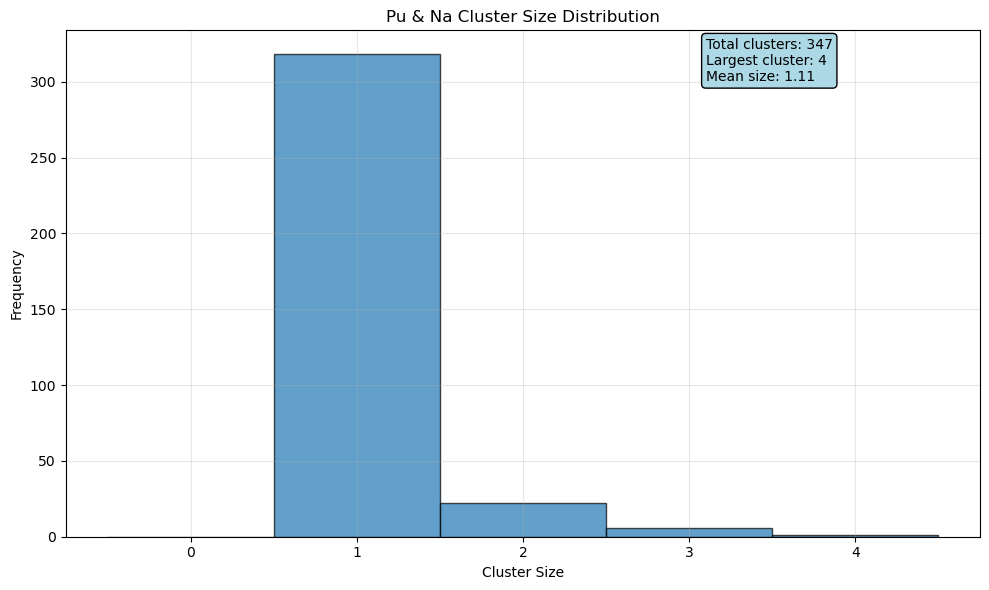

In [16]:
# 1. Plot cluster size distribution
print("=== Creating Cluster Size Distribution Plot ===")
plot_cluster_size_distribution(sizes, "Pu & Na Cluster Size Distribution")


In [17]:
sizes

array([1, 3, 1, 2, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

=== Analyzing Cluster Composition ===


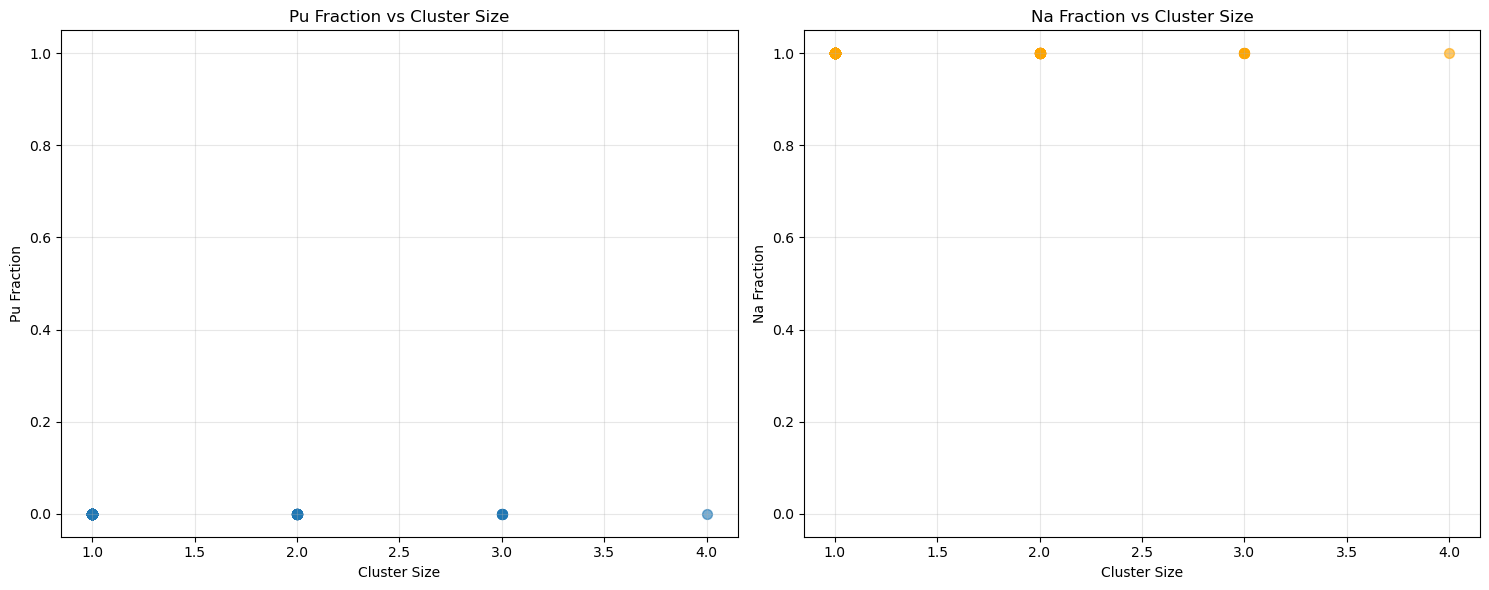

Cluster Composition Analysis:
Total clusters: 347
Pure Pu clusters: 0
Pure Na clusters: 347
Mixed clusters: 0


In [18]:
# 2. Analyze cluster composition (Pu vs Na)
print("=== Analyzing Cluster Composition ===")
cluster_compositions = plot_cluster_composition_analysis(data_analysis, cluster_ids, names_analysis)


=== Analyzing Bond Network ===


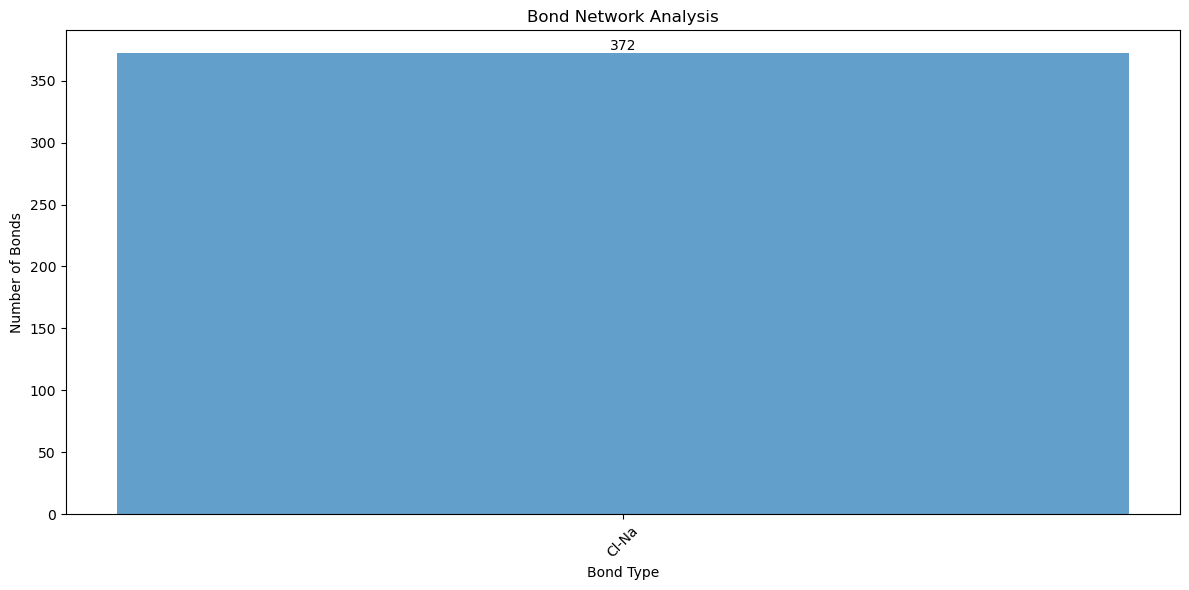

Bond Network Summary:
Cl-Na: 372 bonds


In [19]:
# 3. Analyze bond network
print("=== Analyzing Bond Network ===")
bond_counts = analyze_bond_network(data_analysis, names_analysis)


=== Creating 3D Cluster Visualization ===


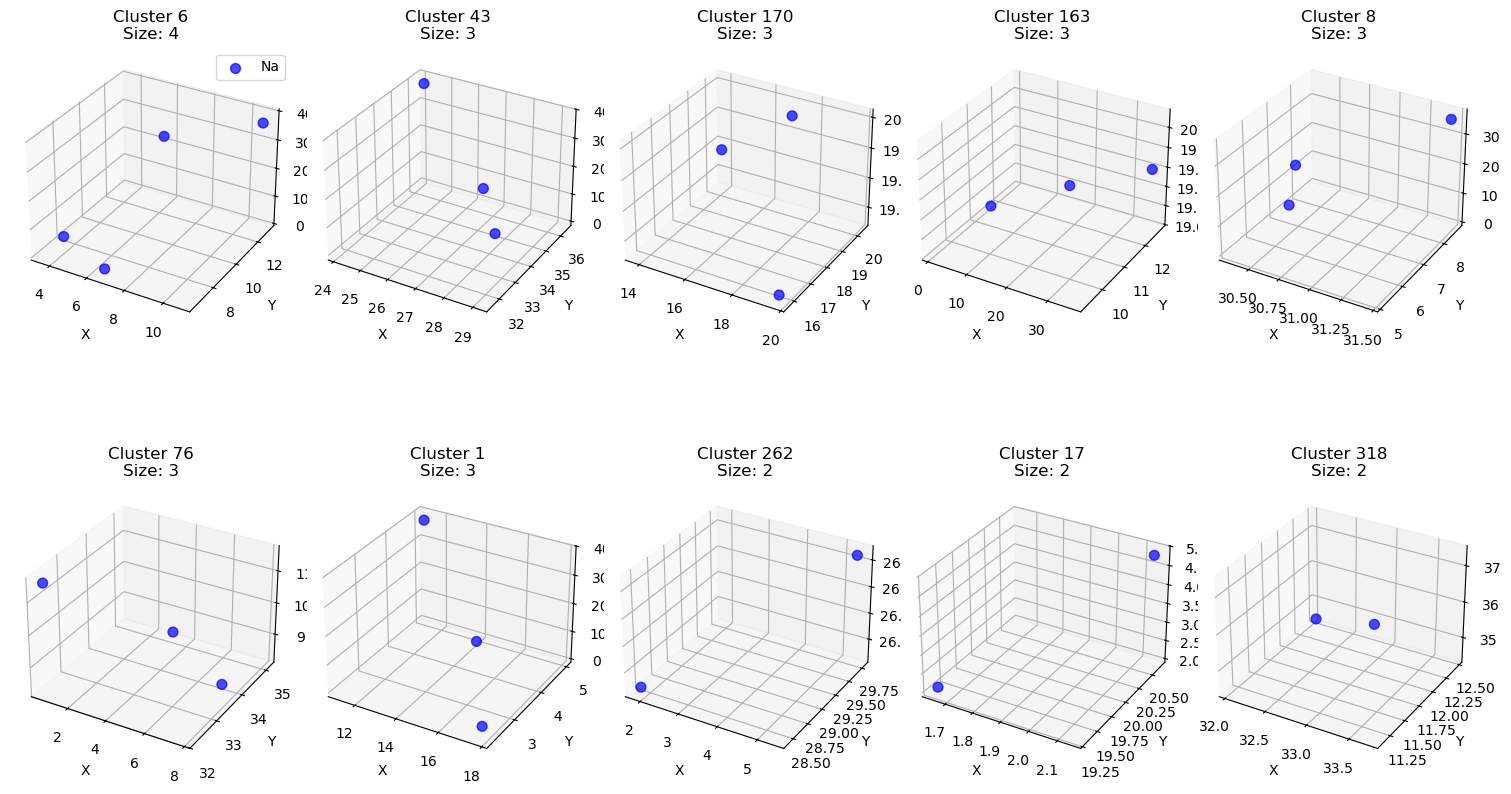

In [20]:
# 4. 3D visualization of largest clusters
print("=== Creating 3D Cluster Visualization ===")
plot_3d_cluster_visualization(data_analysis, cluster_ids, names_analysis, max_clusters=10)


In [22]:
names_analysis

array(['Pu', 'Cl', 'Cl', ..., 'Na', 'Pu', 'Cl'],
      shape=(1792,), dtype='<U2')

=== Testing Graph-Based Visualization ===
Graph has 384 nodes and 39 edges
First few edges: [(9, 29), (15, 186), (22, 25), (22, 1640), (25, 1640), (29, 1621), (39, 1635), (39, 1658), (82, 284), (124, 125)]


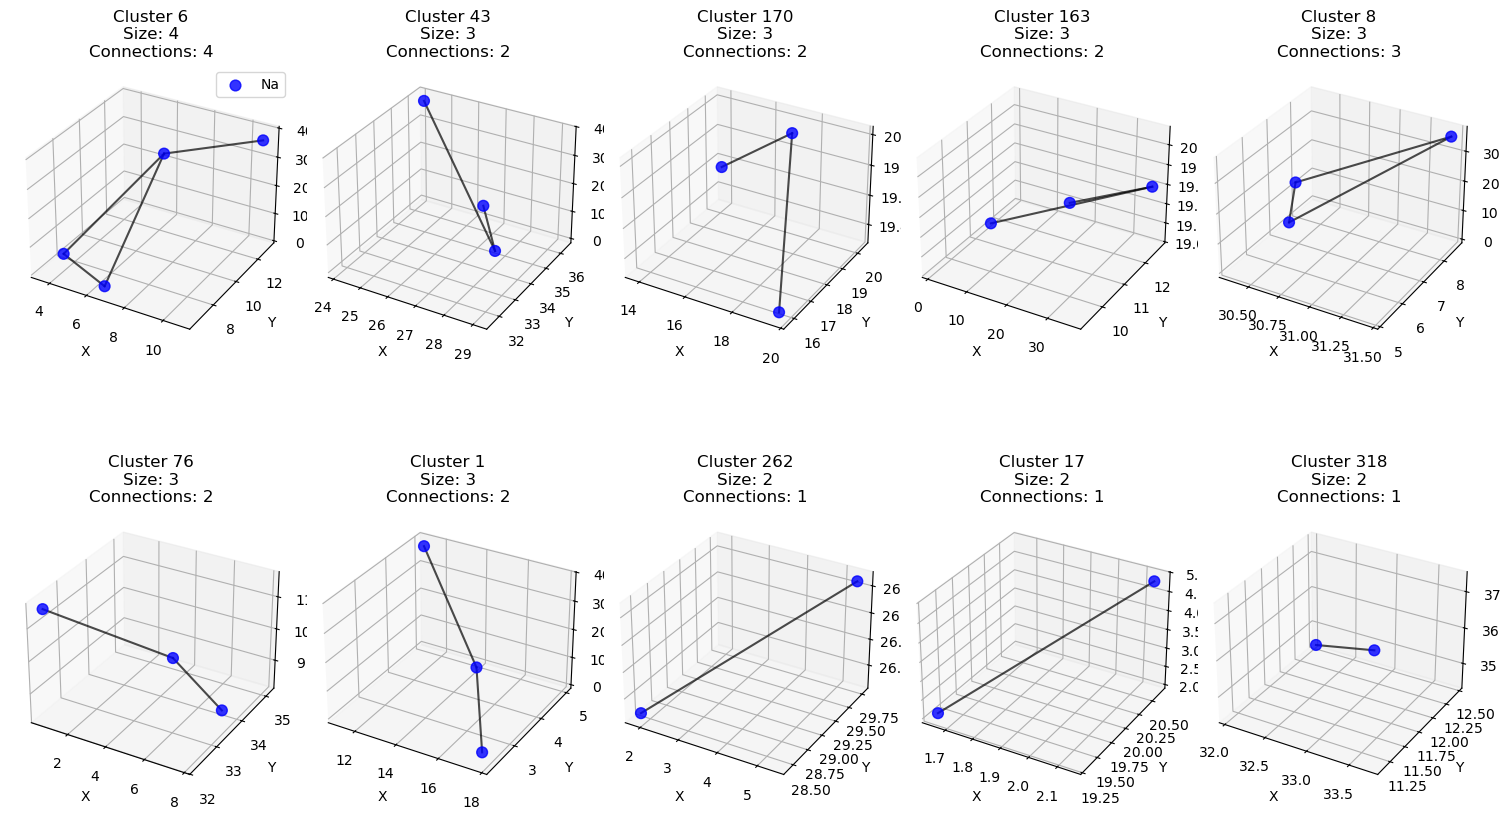

In [23]:
# Test the graph-based visualization
print("=== Testing Graph-Based Visualization ===")
try:
    # Run cluster analysis to get the graph G
    sizes, cluster_ids, G = clusters_shared_anion_rdf(frame=0)
    
    # Get data for visualization
    data_analysis = pipe.compute(0)
    particle_types = data_analysis.particles['Particle Type']
    types = data_analysis.particles.particle_types
    names_analysis = np.array([types.type_by_id(t).name for t in particle_types])
    
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"First few edges: {list(G.edges())[:10]}")
    
    # Use the graph-based visualization
    plot_3d_cluster_with_graph(data_analysis, cluster_ids, names_analysis, G, max_clusters=10)
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


=== Analyzing Pu-Cl and Na-Cl Clusters Separately ===

Pu-Cl Cluster Analysis:
Number of clusters containing Pu: 0


ValueError: max() arg is an empty sequence

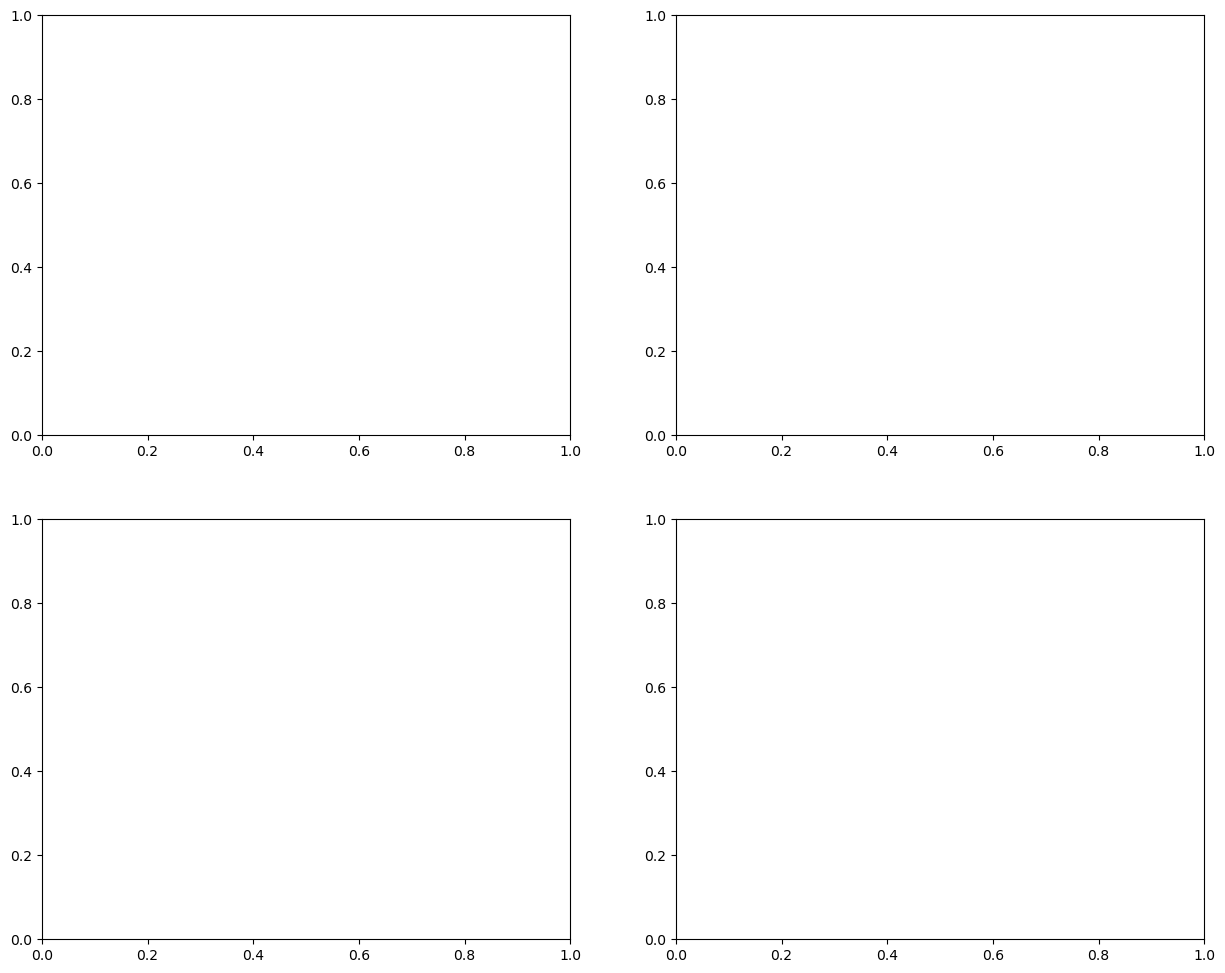

In [42]:
# 5. Separate analysis for Pu-Cl and Na-Cl clusters
print("=== Analyzing Pu-Cl and Na-Cl Clusters Separately ===")

def analyze_metal_chloride_clusters(data, cluster_ids, names, metal_type):
    """Analyze clusters for a specific metal type"""
    is_metal = (names == metal_type)
    is_Cl = (names == 'Cl')
    
    # Find clusters containing this metal type
    metal_clusters = set()
    for i, is_m in enumerate(is_metal):
        if is_m and cluster_ids[i] >= 0:
            metal_clusters.add(cluster_ids[i])
    
    print(f"\n{metal_type}-Cl Cluster Analysis:")
    print(f"Number of clusters containing {metal_type}: {len(metal_clusters)}")
    
    # Analyze each cluster
    cluster_info = []
    for cid in metal_clusters:
        cluster_mask = (cluster_ids == cid)
        metal_count = np.sum(is_metal & cluster_mask)
        cl_count = np.sum(is_Cl & cluster_mask)
        total_count = metal_count + cl_count
        
        cluster_info.append({
            'cluster_id': cid,
            'metal_count': metal_count,
            'cl_count': cl_count,
            'total_count': total_count,
            'metal_cl_ratio': metal_count / cl_count if cl_count > 0 else float('inf')
        })
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Cluster size distribution
    sizes = [c['total_count'] for c in cluster_info]
    bins = np.arange(0, max(sizes) + 2) - 0.5
    ax1.hist(sizes, bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Cluster Size')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{metal_type}-Cl Cluster Size Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Metal-Cl ratio
    ratios = [c['metal_cl_ratio'] for c in cluster_info if c['metal_cl_ratio'] != float('inf')]
    ax2.hist(ratios, bins=20, alpha=0.7, edgecolor='black')
    ax2.set_xlabel(f'{metal_type}/Cl Ratio')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{metal_type}/Cl Ratio Distribution')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Metal count vs Cl count
    metal_counts = [c['metal_count'] for c in cluster_info]
    cl_counts = [c['cl_count'] for c in cluster_info]
    ax3.scatter(metal_counts, cl_counts, alpha=0.6, s=50)
    ax3.set_xlabel(f'{metal_type} Count')
    ax3.set_ylabel('Cl Count')
    ax3.set_title(f'{metal_type} vs Cl Count in Clusters')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Cluster size vs Metal-Cl ratio
    ratios_finite = [r for r in ratios if r != float('inf')]
    sizes_finite = [sizes[i] for i, r in enumerate([c['metal_cl_ratio'] for c in cluster_info]) if r != float('inf')]
    ax4.scatter(sizes_finite, ratios_finite, alpha=0.6, s=50)
    ax4.set_xlabel('Cluster Size')
    ax4.set_ylabel(f'{metal_type}/Cl Ratio')
    ax4.set_title(f'Cluster Size vs {metal_type}/Cl Ratio')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Average cluster size: {np.mean(sizes):.2f}")
    print(f"Largest cluster size: {max(sizes)}")
    print(f"Average {metal_type}/Cl ratio: {np.mean(ratios):.2f}")
    print(f"Clusters with {metal_type}/Cl = 1: {sum(1 for r in ratios if abs(r - 1.0) < 0.1)}")
    
    return cluster_info

# Analyze Pu-Cl clusters
pu_cluster_info = analyze_metal_chloride_clusters(data_analysis, cluster_ids, names_analysis, 'Pu')

# Analyze Na-Cl clusters  
na_cluster_info = analyze_metal_chloride_clusters(data_analysis, cluster_ids, names_analysis, 'Na')


In [ ]:
# 6. Summary comparison plot
print("=== Creating Summary Comparison Plot ===")

def create_summary_comparison(pu_info, na_info):
    """Create a comprehensive comparison plot"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Cluster size comparison
    pu_sizes = [c['total_count'] for c in pu_info]
    na_sizes = [c['total_count'] for c in na_info]
    
    ax1.hist(pu_sizes, bins=20, alpha=0.6, label='Pu-Cl clusters', color='red', edgecolor='black')
    ax1.hist(na_sizes, bins=20, alpha=0.6, label='Na-Cl clusters', color='blue', edgecolor='black')
    ax1.set_xlabel('Cluster Size')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Cluster Size Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Metal-Cl ratio comparison
    pu_ratios = [c['metal_cl_ratio'] for c in pu_info if c['metal_cl_ratio'] != float('inf')]
    na_ratios = [c['metal_cl_ratio'] for c in na_info if c['metal_cl_ratio'] != float('inf')]
    
    ax2.hist(pu_ratios, bins=20, alpha=0.6, label='Pu/Cl ratio', color='red', edgecolor='black')
    ax2.hist(na_ratios, bins=20, alpha=0.6, label='Na/Cl ratio', color='blue', edgecolor='black')
    ax2.set_xlabel('Metal/Cl Ratio')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Metal/Cl Ratio Distribution Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot of cluster composition
    pu_metal_counts = [c['metal_count'] for c in pu_info]
    pu_cl_counts = [c['cl_count'] for c in pu_info]
    na_metal_counts = [c['metal_count'] for c in na_info]
    na_cl_counts = [c['cl_count'] for c in na_info]
    
    ax3.scatter(pu_metal_counts, pu_cl_counts, alpha=0.6, s=50, color='red', label='Pu-Cl')
    ax3.scatter(na_metal_counts, na_cl_counts, alpha=0.6, s=50, color='blue', label='Na-Cl')
    ax3.set_xlabel('Metal Count')
    ax3.set_ylabel('Cl Count')
    ax3.set_title('Metal vs Cl Count in Clusters')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Box plot comparison
    data_to_plot = [pu_sizes, na_sizes]
    ax4.boxplot(data_to_plot, labels=['Pu-Cl', 'Na-Cl'], patch_artist=True)
    ax4.set_ylabel('Cluster Size')
    ax4.set_title('Cluster Size Distribution (Box Plot)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== SUMMARY COMPARISON ===")
    print(f"Pu-Cl clusters: {len(pu_info)}")
    print(f"  Average size: {np.mean(pu_sizes):.2f}")
    print(f"  Largest size: {max(pu_sizes) if pu_sizes else 0}")
    print(f"  Average Pu/Cl ratio: {np.mean(pu_ratios):.2f}")
    
    print(f"\nNa-Cl clusters: {len(na_info)}")
    print(f"  Average size: {np.mean(na_sizes):.2f}")
    print(f"  Largest size: {max(na_sizes) if na_sizes else 0}")
    print(f"  Average Na/Cl ratio: {np.mean(na_ratios):.2f}")

# Create the summary comparison
create_summary_comparison(pu_cluster_info, na_cluster_info)


In [ ]:
data = pipe.compute(0)
topo = data.particles.bonds.topology  # Nx2 array of (i,j)
# Example: build a graph among metals only
import networkx as nx, numpy as np
names = np.array([data.particles.particle_types.type_by_id(t).name
                  for t in data.particles['Particle Type']])
is_metal =  (names=='Na')

G = nx.Graph()
G.add_nodes_from(np.where(is_metal)[0].tolist())
for a,b in topo:
    if is_metal[a] and is_metal[b]:
        G.add_edge(int(a), int(b))


In [ ]:
# Summary analysis for Pu-Cl disabled case
print("=== SUMMARY: Pu-Cl DISABLED Analysis ===")
print(f"Configuration: Pu-Cl bonds disabled (r_PuCl = {r_PuCl}), Na-Cl bonds enabled (r_NaCl = {r_NaCl:.3f})")
print(f"Total clusters found: {len(sizes)}")
print(f"Cluster sizes: {sizes}")
print(f"Graph connectivity: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Non-isolated metal atoms: {np.sum(cluster_ids >= 0)}")

if len(sizes) > 0:
    print(f"Largest cluster: {np.max(sizes)} atoms")
    print(f"Average cluster size: {np.mean(sizes):.2f} atoms")
    print(f"Cluster size distribution: {np.bincount(sizes)}")
else:
    print("No clusters found - all metal atoms are isolated!")

print("\nThis analysis shows clustering behavior when Pu-Cl bonds are disabled.")
print("Only Na-Cl bonds are active, so clustering depends on shared Cl atoms between Na atoms.")
